In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DWL_PRODUCT_MASTER_DIM'
    
    # Important to look
    QUERY = f"""SELECT * FROM DW_ANALYTICS.{TABLE_NAME}"""
    
    # Derived values
    DATA_FP = f'./data/{TABLE_NAME}'
    IMG_FP = f'./img/{TABLE_NAME}'
    
    
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if 'DIM' in NAMESPACE.TABLE_NAME:
            NAMESPACE.saved_file = os.path.join(NAMESPACE.DATA_FP, NAMESPACE.TABLE_NAME)
        if not os.path.exists(NAMESPACE.DATA_FP):
            os.makedirs(NAMESPACE.DATA_FP)
        if not os.path.exists(NAMESPACE.IMG_FP):
            os.makedirs(NAMESPACE.IMG_FP)

In [6]:
NAMESPACE.QUERY

'SELECT * FROM DW_ANALYTICS.DWL_PRODUCT_MASTER_DIM'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

DATA_FP
IMG_FP
QUERY
TABLE_NAME
init
saved_file
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.IMG_FP, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.IMG_FP, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# EXECUTE

In [18]:
NAMESPACE.QUERY

'SELECT * FROM DW_ANALYTICS.DWL_PRODUCT_MASTER_DIM'

In [19]:
df = download_or_reload(NAMESPACE.saved_file)

Len 2461


In [20]:
df

,COMPANY_KEY,PRODUCT_LINE,CATEGORY_CDE,APP,INSURANCE_ID,FTPUD_ID,CHARGE_CDE,PL_CATEGORY,PRODUCT_ID_INSURANCE,PRODUCT_ID_LVL_3,...,INPUT_DT,AUTHORISE_ID,AUTHORISE_DT,ATTR6,ATTR7,ATTR8,ATTR9,ATTR10,REC_CREATE_DT,REC_UPDATE_DT
0,1,-1,8150,220,-1,-1,-1,-1,-1,1309,...,2018-07-06 13:46:29,None,1900-01-01,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
1,1,-1,8150,240,-1,-1,-1,-1,-1,1310,...,2018-07-06 13:46:29,None,1900-01-01,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
2,1,-1,8150,260,-1,-1,-1,-1,-1,1311,...,2018-07-06 13:46:29,None,1900-01-01,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
3,1,-1,8150,107,-1,-1,-1,-1,-1,1312,...,2018-07-06 13:46:29,None,1900-01-01,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
4,1,10054,8150,107,-1,-1,-1,-1,-1,1313,...,2018-07-06 13:46:29,None,1900-01-01,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,1,-1,-1,-1,B,BPR,-1,-1,848042,3541,...,2018-07-06 13:46:29,vybd,2019-12-19,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
2457,1,-1,-1,-1,B,BPR,-1,-1,875213,3541,...,2018-07-06 13:46:29,vybd,2019-12-19,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
2458,1,-1,-1,-1,B,BPR,-1,-1,875269,3541,...,2018-07-06 13:46:29,vybd,2019-12-19,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03
2459,1,-1,-1,-1,B,BPR,-1,-1,16405008,3543,...,2018-07-06 13:46:29,vybd,2022-03-23,None,None,None,None,None,2022-11-21 00:40:03,2022-11-21 00:40:03


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,COMPANY_KEY,0.000000,int64,1,0.000406,[1]
1,PRODUCT_LINE,0.000000,object,768,0.312068,"[-1, 10054, 10043]"
2,CATEGORY_CDE,0.000000,object,97,0.039415,"[8150, 8101, 8100]"
3,APP,0.000000,object,86,0.034945,"[220, 240, 260]"
4,INSURANCE_ID,0.000000,object,744,0.302316,"[-1, 4120, 4121]"
5,FTPUD_ID,0.000000,object,46,0.018692,"[-1, A, PL62161]"
6,CHARGE_CDE,0.000000,object,53,0.021536,"[-1, 1024, 1020]"
7,PL_CATEGORY,0.000000,object,16,0.006501,"[-1, Thanh toan LCNK, FWTGSP]"
8,PRODUCT_ID_INSURANCE,0.000000,object,431,0.175132,"[-1, Bao co LCXK, Bao co Nho thu XK]"
9,PRODUCT_ID_LVL_3,0.000000,int64,1512,0.614384,"[1309, 1310, 1311]"


In [22]:
df.describe()

,COMPANY_KEY,PRODUCT_ID_LVL_3,PRODUCT_ID_LVL_2,PRODUCT_ID_LVL_1,DAO_PRIORITY,ACTIVE
count,2461.0,2461.000000,2453.000000,2452.000000,2461.000000,2461.00000
mean,1.0,2731.348639,1711.045658,1007.601550,2.698090,0.99553
std,0.0,933.249849,1080.312031,4.429774,1.444175,0.06672
min,1.0,101.000000,10.000000,1000.000000,0.000000,0.00000
25%,1.0,1907.000000,1092.000000,1005.000000,1.000000,1.00000
50%,1.0,3189.000000,1115.000000,1008.000000,3.000000,1.00000
75%,1.0,3458.000000,3500.000000,1011.000000,4.000000,1.00000
max,1.0,5069.000000,5052.000000,1015.000000,4.000000,1.00000


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', ''
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
2,CATEGORY_CDE,0.000000,object,97,0.039415,"[8150, 8101, 8100]"
3,APP,0.000000,object,86,0.034945,"[220, 240, 260]"
5,FTPUD_ID,0.000000,object,46,0.018692,"[-1, A, PL62161]"
6,CHARGE_CDE,0.000000,object,53,0.021536,"[-1, 1024, 1020]"
7,PL_CATEGORY,0.000000,object,16,0.006501,"[-1, Thanh toan LCNK, FWTGSP]"
8,PRODUCT_ID_INSURANCE,0.000000,object,431,0.175132,"[-1, Bao co LCXK, Bao co Nho thu XK]"
9,PRODUCT_ID_LVL_3,0.000000,int64,1512,0.614384,"[1309, 1310, 1311]"
11,PRODUCT_ID_LVL_2,0.003251,float64,162,0.065827,"[1037.0, 1038.0, 1041.0]"
12,PRODUCT_NM_LVL_2,0.003657,object,159,0.064608,"[Tiết kiệm truyền thống, Tiết kiệm Điều hòa vố..."
13,PRODUCT_ID_LVL_1,0.003657,float64,16,0.006501,"[1000.0, 1001.0, 1002.0]"


In [24]:
valid_info = data_stats

,default_func,remove_mode_value,logx
count,2461.000,0.000,0.000
count_pct_chg,100.000,-100.000,-100.000
mean,1.000,NaN,NaN
mean_pct_chg,100.000,NaN,NaN
median,1.000,NaN,NaN
median_pct_chg,100.000,NaN,NaN
min,1.000,NaN,NaN
min_pct_chg,100.000,NaN,NaN
max,1.000,NaN,NaN
max_pct_chg,100.000,NaN,NaN


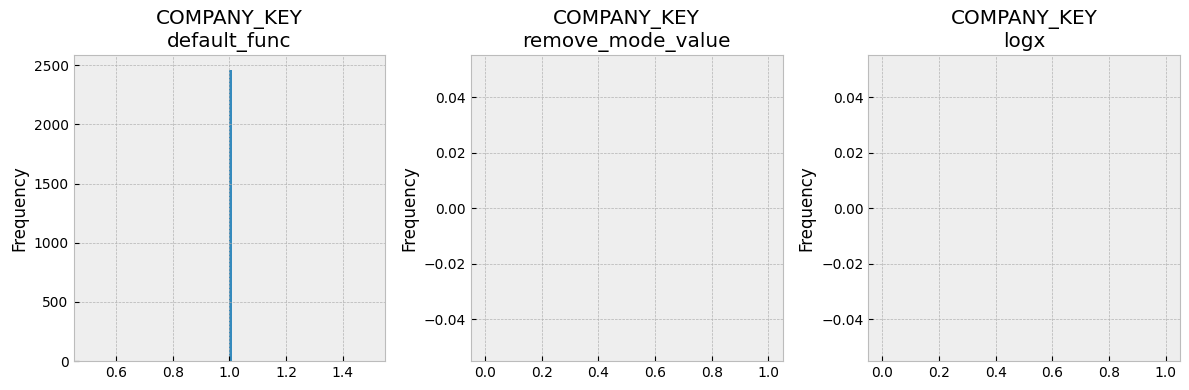

-1       1474
10045      16
50006      14
50012      13
50011      12
         ... 
9332        1
7503        1
7903        1
7907        1
11054       1
Name: PRODUCT_LINE, Length: 768, dtype: int64

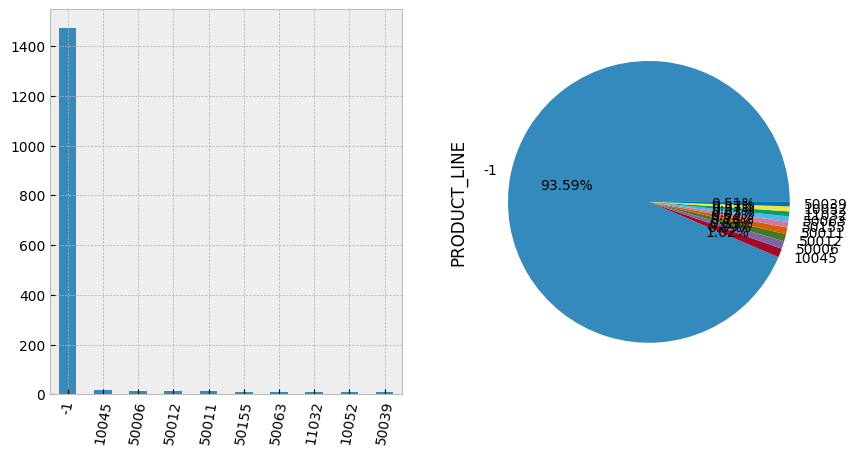

-1       1865
21050     173
8150       58
21060      56
1001       44
         ... 
1008        1
1007        1
1030        1
1031        1
1018        1
Name: CATEGORY_CDE, Length: 97, dtype: int64

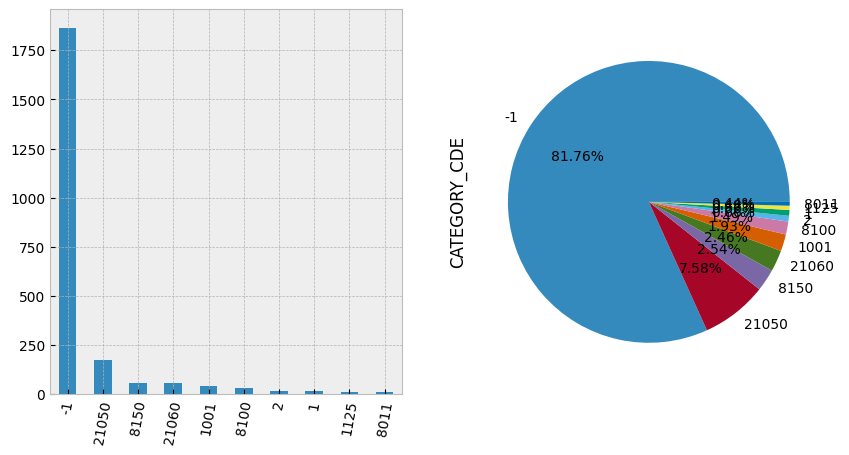

-1     2329
212       4
312       4
200       4
300       4
       ... 
157       1
158       1
163       1
164       1
161       1
Name: APP, Length: 86, dtype: int64

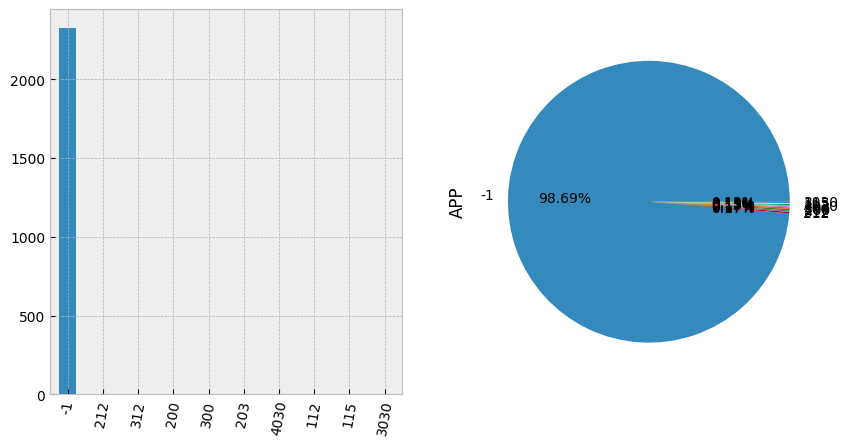

-1      1052
B        384
SP        24
OTR3      18
M         16
        ... 
1395       1
1396       1
1397       1
1398       1
2929       1
Name: INSURANCE_ID, Length: 744, dtype: int64

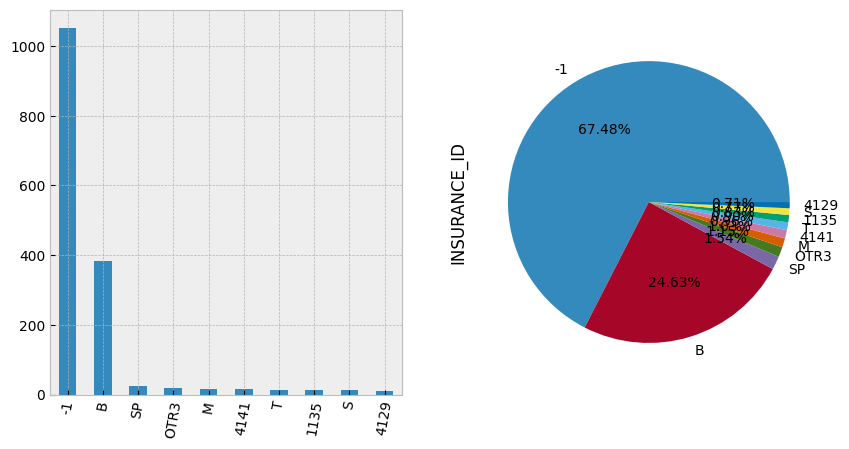

-1         1945
BPR         418
I            14
XFR           8
PMT           7
XAU           6
SBJ           6
G             4
SMC           4
LOP           3
UPL           2
-1            2
TPC           2
DST           2
CCP           2
QRP           2
BVP           2
COM           2
1             2
M             2
FTD           1
DUHO          1
PL62171       1
11            1
PL62202       1
PL62105       1
PL62161       1
CHBE          1
COTA          1
TRCA          1
DTTR          1
DICU          1
THKE          1
THUN          1
DULI          1
DVGT          1
DVKH          1
DTGR          1
DTX           1
DTTV          1
DTGV          1
CNKH          1
DATU          1
A             1
DTUV          1
DTUR          1
Name: FTPUD_ID, dtype: int64

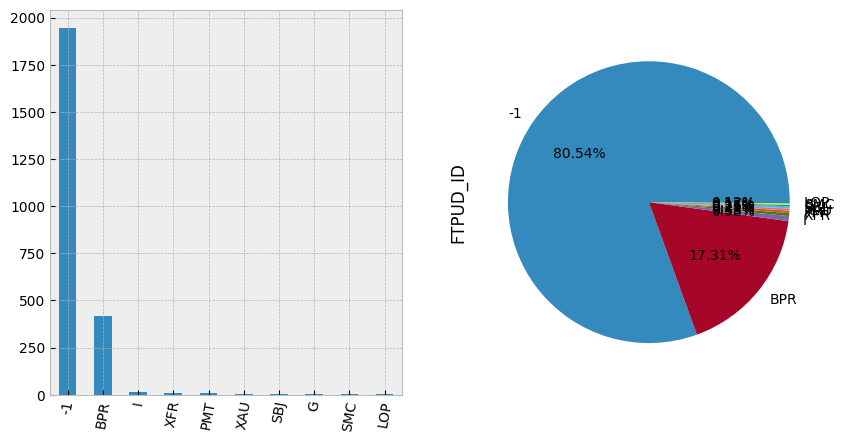

-1          2363
USD            6
XAU            6
KHR            5
LAK            5
THB            5
1001           5
CCHKR          3
IRUSR          3
RUSER          3
1              3
IRUSER         2
1022           2
1020           2
1021           2
1025           2
C              2
A              2
1024           2
CMKER          2
ICUSR          2
CNY            2
1023           2
3              1
-1             1
2201           1
2              1
2205           1
2204           1
2203           1
2207           1
-1             1
2206           1
2202           1
NSMAKER        1
2200           1
CCTFONLY       1
ALERT_ID       1
04             1
1066           1
1060           1
01             1
1014           1
1015           1
1z016          1
1011           1
NSCCHKR        1
CMKER:         1
SALMAKER       1
CCHKRTF        1
CMKERTF        1
CMTFONLY       1
-1             1
Name: CHARGE_CDE, dtype: int64

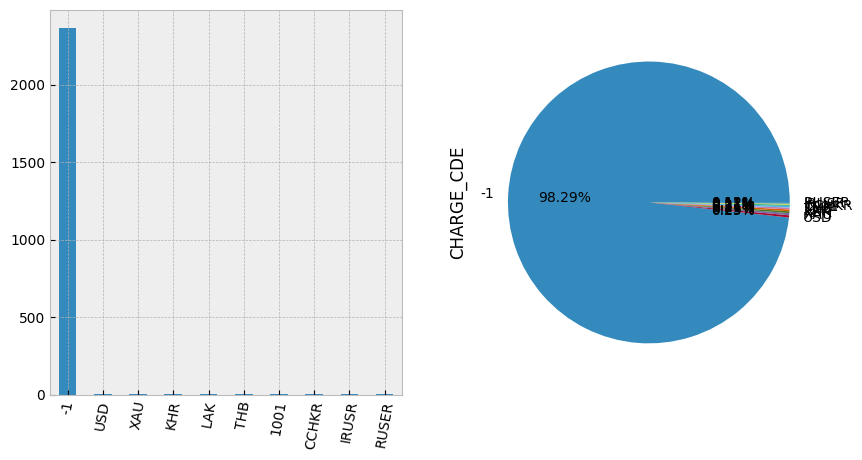

-1                       2358
A                          36
C                          23
MOIGIOI                     9
INTWEB.INP                  9
Phat hanh LCNK              8
Thanh toan LCNK             7
1                           3
FWTGSP                      1
SW100                       1
OPT-EXC                     1
FX.IB                       1
0                           1
Thanh toan Nho thu NK       1
Chuyen tien quoc te         1
-1                          1
Name: PL_CATEGORY, dtype: int64

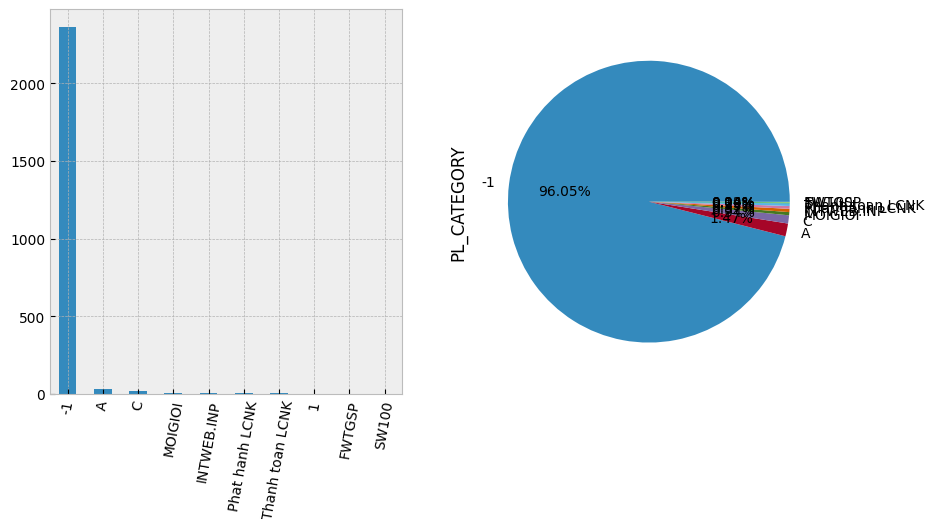

-1          1954
HC_DLVN       11
VE_DLVN       11
DL_DLVN        8
11             7
            ... 
1162711        1
38             1
39             1
37             1
16074372       1
Name: PRODUCT_ID_INSURANCE, Length: 431, dtype: int64

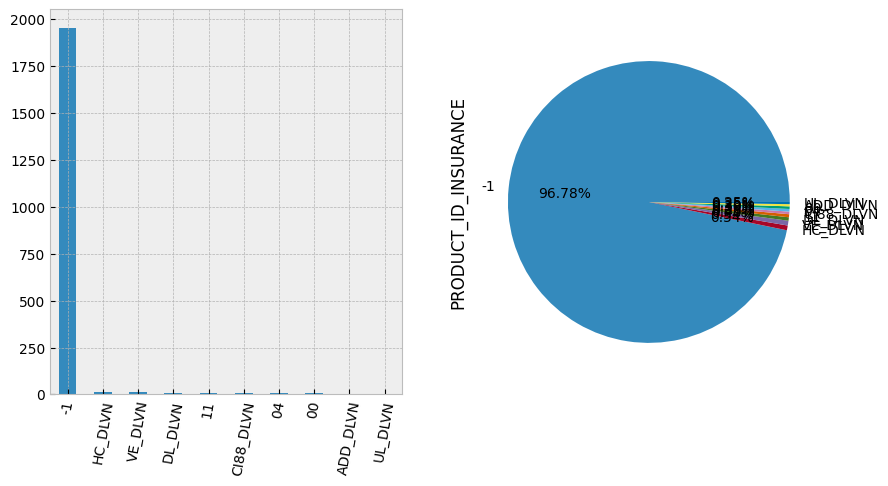

,default_func,remove_mode_value,logx
count,2461.000,2146.000,2146.000
count_pct_chg,100.000,-12.800,-12.800
mean,2731.349,2612.504,7.785
mean_pct_chg,100.000,-4.351,-99.715
median,3189.000,2772.500,7.928
median_pct_chg,100.000,-13.061,-99.751
min,101.000,101.000,4.615
min_pct_chg,100.000,0.000,-95.431
max,5069.000,5069.000,8.531
max_pct_chg,100.000,0.000,-99.832


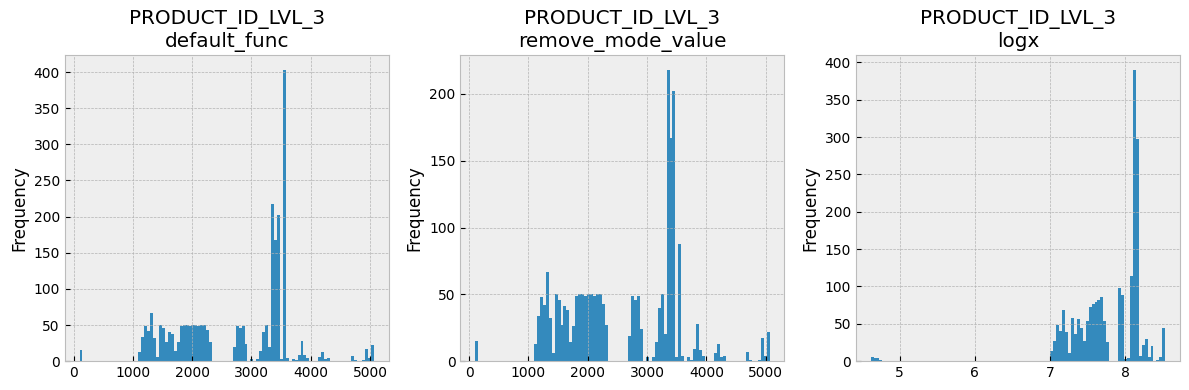

Thanh toán hóa đơn trên IB - Điện         315
Thanh toán hóa đơn trên IB - Nước          42
Thanh toán HĐ qua IB - Viễn thông          23
Chuyển tiền đi 1H sang Lào, Cam            20
Thanh toán tại Quầy - Điện GIA LAI         15
                                         ... 
TEST - BIN 211200                           1
PassportPlus - Payroll                      1
PassportPlus - Staff                        1
PassportPlus                                1
UTTT HĐ tại quầy- Điện  Lực Ninh Thuận      1
Name: PRODUCT_NM_LVL_3, Length: 1494, dtype: int64

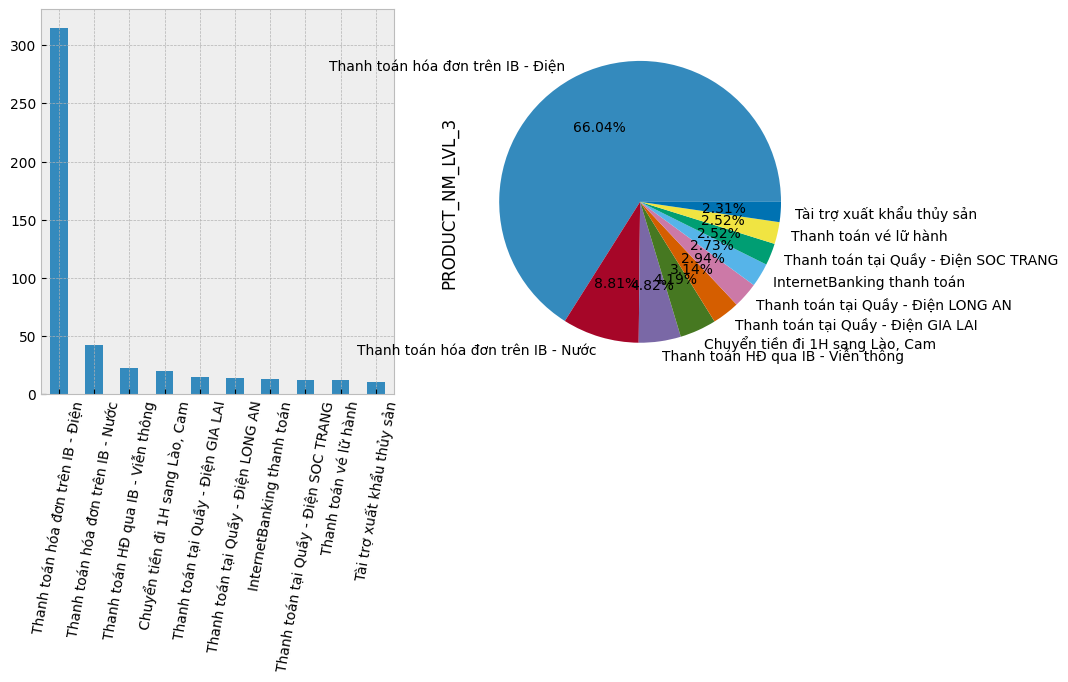

,default_func,remove_mode_value,logx
count,2453.000,2051.000,2051.000
count_pct_chg,100.000,-16.388,-16.388
mean,1711.046,1826.892,7.317
mean_pct_chg,100.000,6.770,-99.572
median,1115.000,1113.000,7.015
median_pct_chg,100.000,-0.179,-99.371
min,10.000,10.000,2.303
min_pct_chg,100.000,0.000,-76.974
max,5052.000,5052.000,8.528
max_pct_chg,100.000,0.000,-99.831


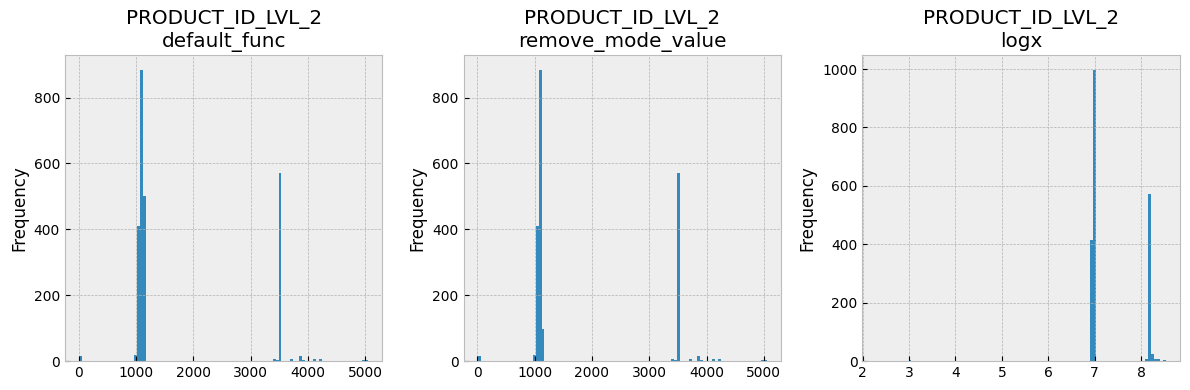

Thanh toán hóa đơn trên IB                  402
Thanh toán hóa đơn tại Quầy - Điện          317
Thẻ tín dụng quốc tế                        266
Thẻ thanh toán quốc tế                       96
InternetBanking                              78
                                           ... 
Vay chứng minh năng lực tài chính             1
VAY CBNV Nguyễn Hoàng Group                   1
Vay mua xe 2 bánh                             1
Quyền chọn                                    1
Bảo lãnh bán và cho thuê mua nhà ở HTTTL      1
Name: PRODUCT_NM_LVL_2, Length: 159, dtype: int64

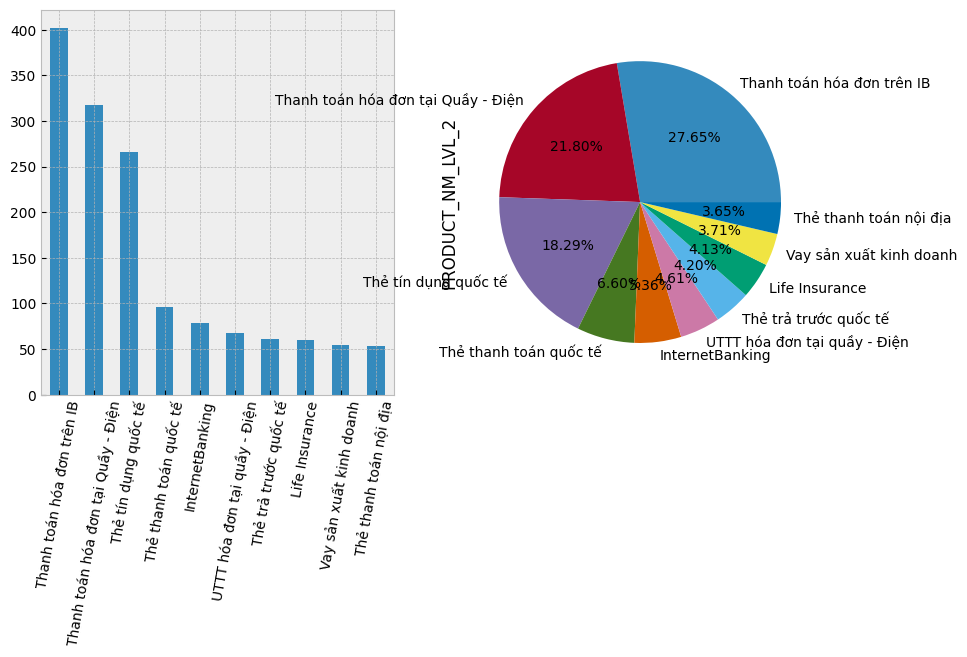

,default_func,remove_mode_value,logx
count,2452.000,1936.000,1936.000
count_pct_chg,100.000,-21.044,-21.044
mean,1007.602,1007.495,6.915
mean_pct_chg,100.000,-0.011,-99.314
median,1008.000,1010.000,6.918
median_pct_chg,100.000,0.198,-99.314
min,1000.000,1000.000,6.908
min_pct_chg,100.000,0.000,-99.309
max,1015.000,1015.000,6.923
max_pct_chg,100.000,0.000,-99.318


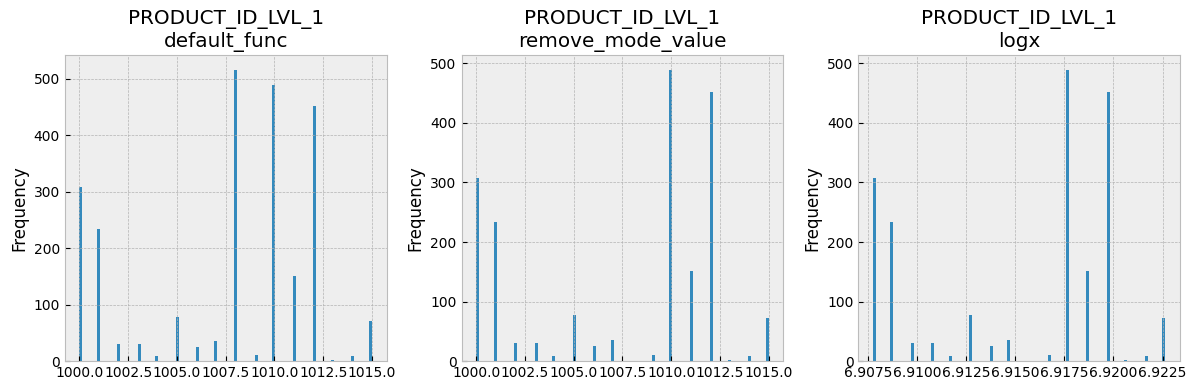

Thẻ                            516
eBanking                       489
Thanh toán tại Quầy            452
Tiền gửi                       308
Tiền vay                       234
UTTT hóa đơn tại quầy          151
Thanh toán quốc tế              78
Insurance                       72
Ngoại hối và phái sinh          36
Góp chợ                         31
Bảo lãnh                        30
Dịch vụ                       25
Alert                           10
Thanh toán nội địa               9
Dịch vụ quản lý dòng tiền      9
Tài trợ chuỗi cung ứng           2
Name: PRODUCT_NM_LVL_1, dtype: int64

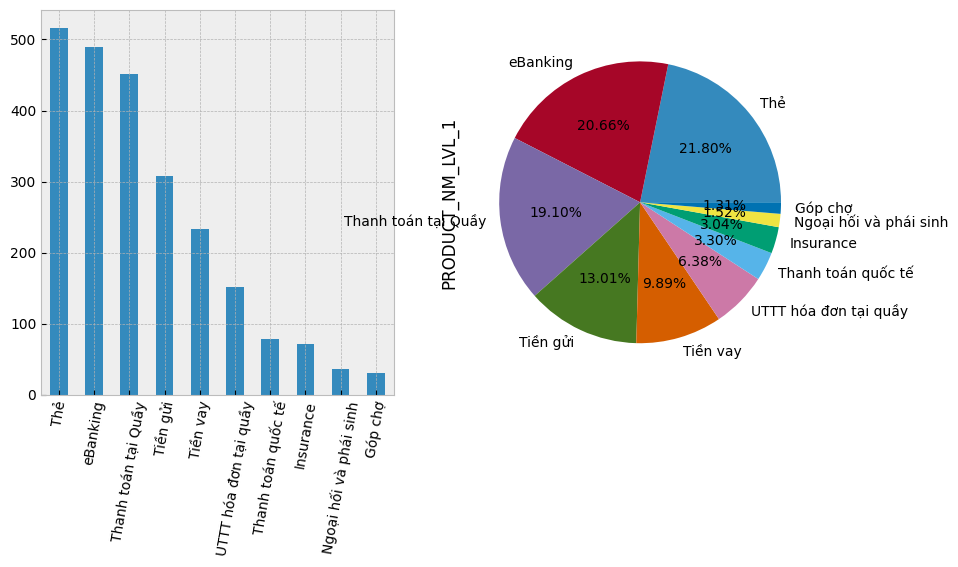

Card                      516
eBanking                  489
Epayment Service          461
Deposit                   308
Loan                      234
Direct Debit              151
International Payment      78
Insurance                  72
Forex Exchange             36
Micro Finance              31
Guarantee                  30
Services                   25
Alert                      10
Domestic Payment            9
Cash Management             9
Supply Chain Financing      2
Name: APPL, dtype: int64

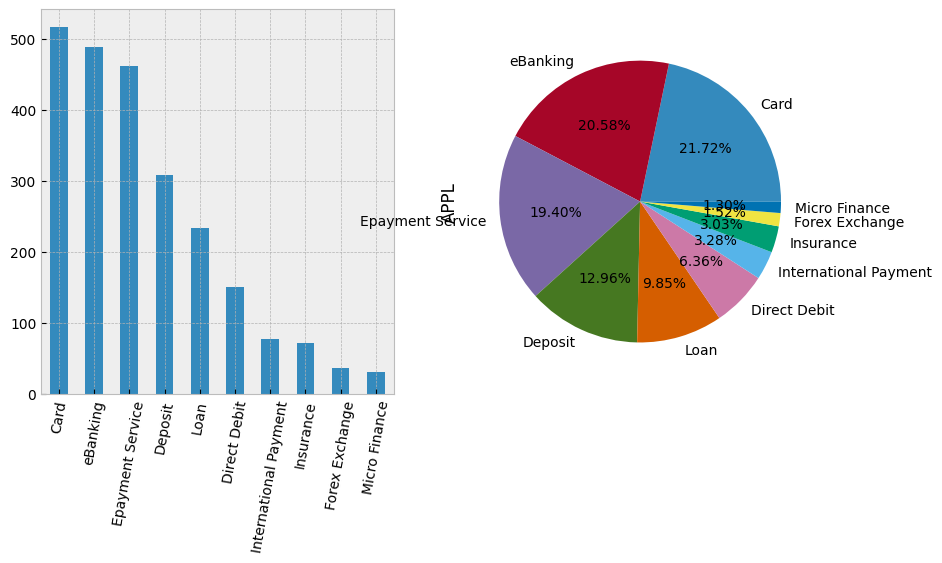

- "International Transfer"."MA_LOAI" = ACT6, ACT7, ACT8, ACTA, ACTO\r\n- "International Transfer"."LOAI_TIEN" = USD, KHR, LAK, THB    20
167.45 Corp Product 4131                                                                                                              11
167.45 Corp Product 4129                                                                                                              11
167.45 Corp Product 4130                                                                                                              11
167.45 Corp Product 4127                                                                                                              11
                                                                                                                                      ..
Chiết khấu HP/BCT L/C nội địa\n                                                                                                        1
Bao thanh toán nội địa                   

) missing from current font..py:8: UserWarning: Glyph 13 (
  plt.savefig(os.path.join(NAMESPACE.IMG_FP, f'{cat_col}.jpg'), dpi=500)
) missing from current font.ython3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


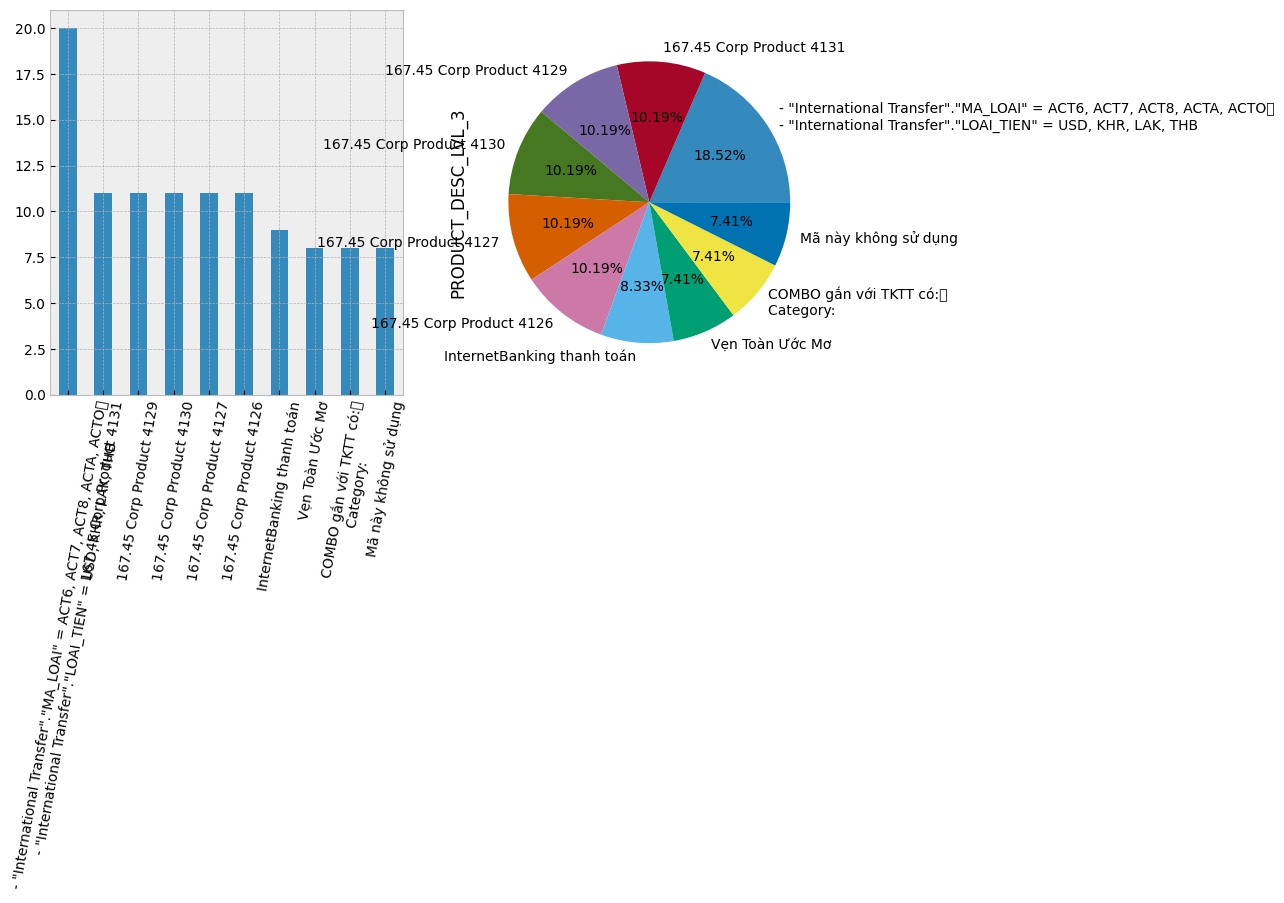

Y    1684
N     666
0      91
1      20
Name: IS_PRODUCT, dtype: int64

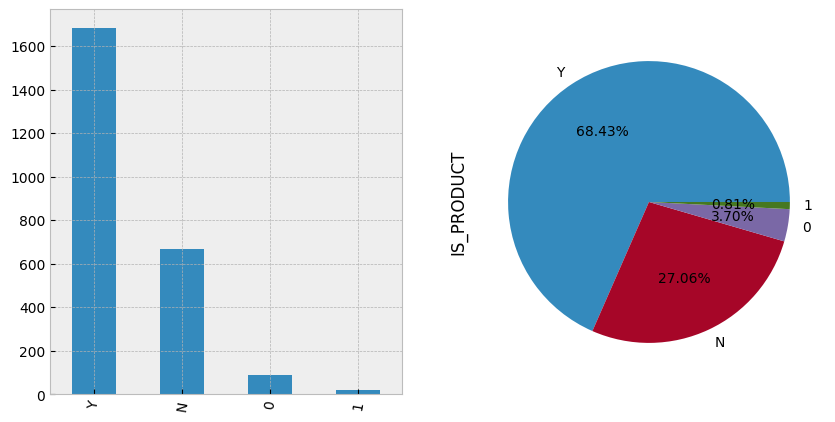

N    1706
Y     644
0      60
1      51
Name: IS_SERVICE, dtype: int64

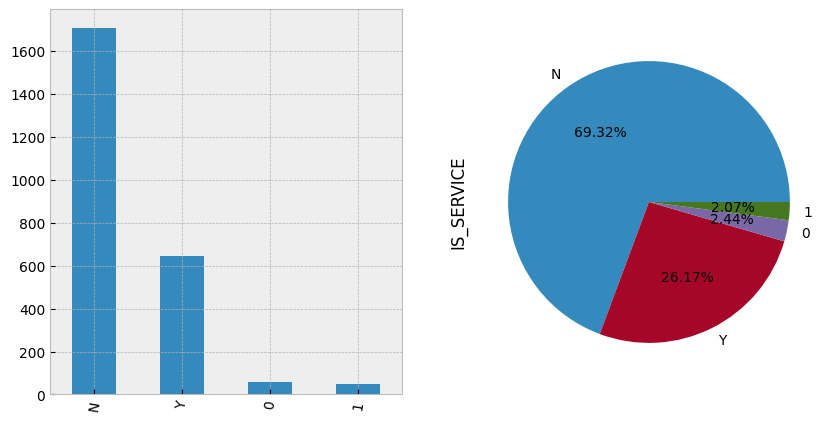

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,2461.000,1314.000,1314.000
count_pct_chg,100.000,-46.607,-46.607
mean,2.698,1.562,-inf
mean_pct_chg,100.000,-42.120,-inf
median,3.000,1.000,0.000
median_pct_chg,100.000,-66.667,-100.000
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,4.000,3.000,1.099
max_pct_chg,100.000,-25.000,-72.535


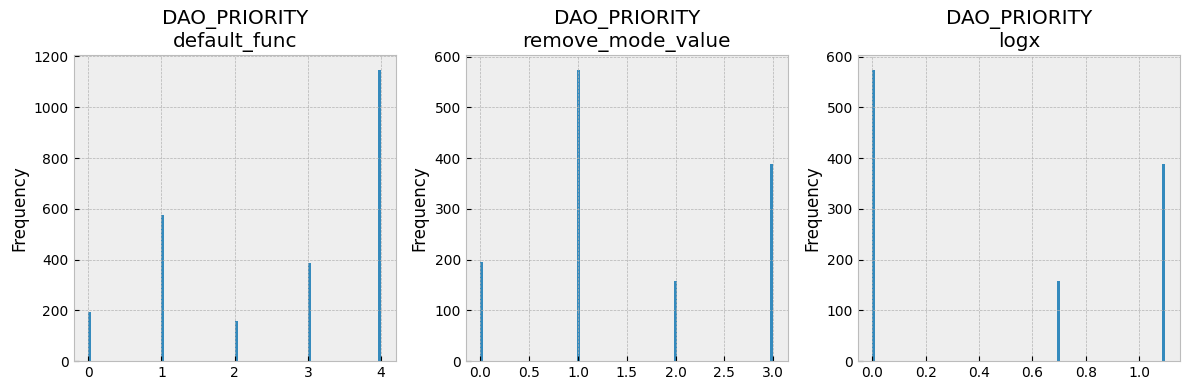

CN         1355
CN + DN     807
DN          297
CN            2
Name: CUSTOMER_TYPE, dtype: int64

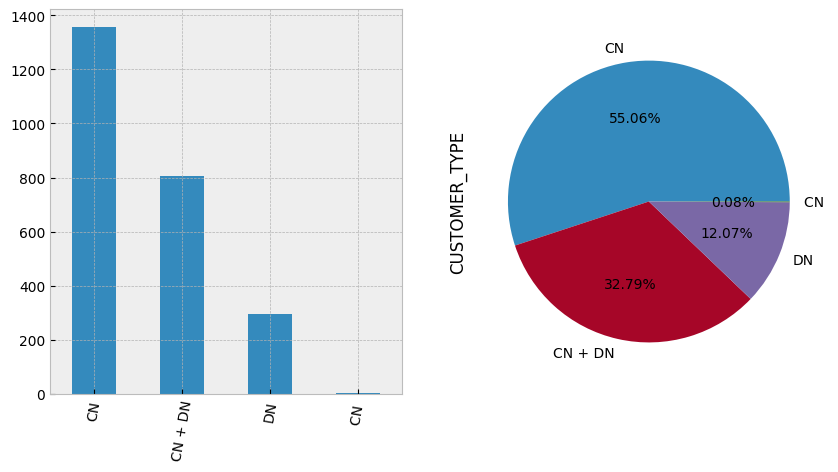

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,2461.000,11.000,11.000
count_pct_chg,100.000,-99.553,-99.553
mean,0.996,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


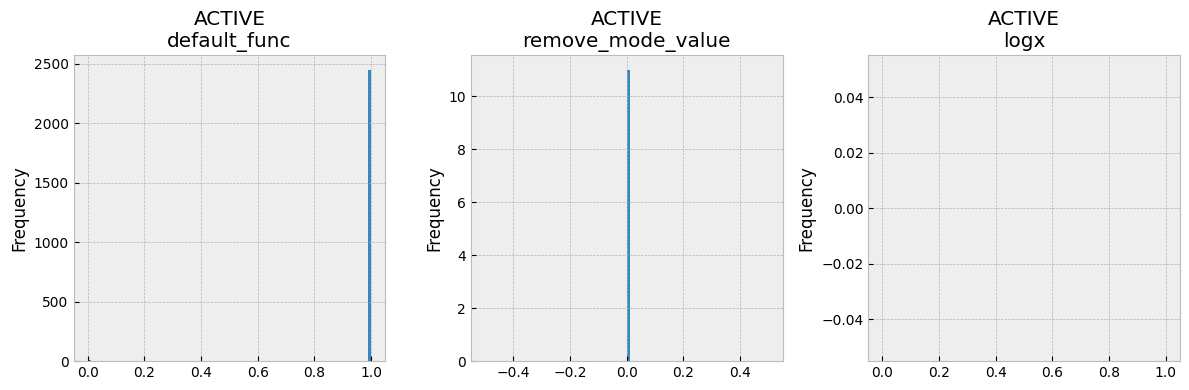

Series([], Name: PATH, dtype: int64)

IndexError: index 0 is out of bounds for axis 0 with size 0

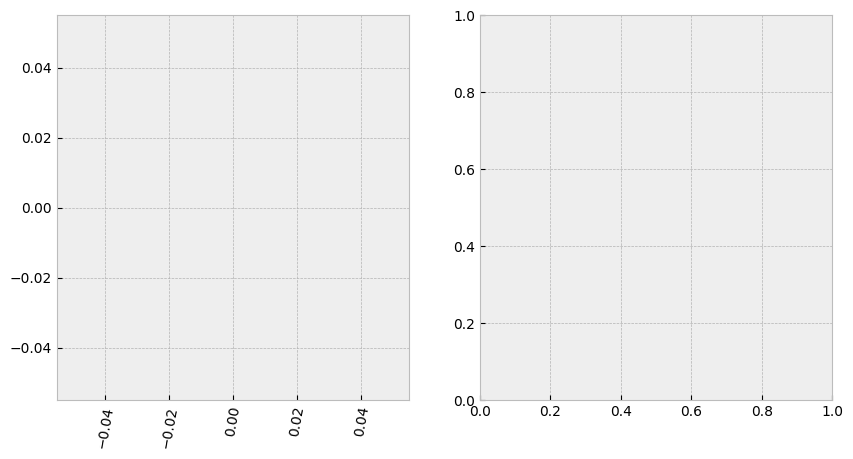

In [25]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [ ]:
df.columns, len(df.columns)

In [ ]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

In [ ]:
df.columns

## COMPARE SAMPLES - SUB1/2/3